In [369]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [370]:
# 讀欄位名稱
df = pd.read_csv("./Farm-gate and wholesale market prices in euro_Meat_0001_2310.csv")
df = df.rename(columns={"(STS.M.I9.N.AGRI.XMEAT0.3.000)":"demand"})
columns = df.columns.tolist()
columns

['DATE', 'TIME PERIOD', 'demand']

In [371]:
df.head

<bound method NDFrame.head of            DATE TIME PERIOD  demand
0    1991-01-31     1991Jan   50.03
1    1991-02-28     1991Feb   52.66
2    1991-03-31     1991Mar   53.82
3    1991-04-30     1991Apr   53.97
4    1991-05-31     1991May   54.81
..          ...         ...     ...
389  2023-06-30     2023Jun  186.02
390  2023-07-31     2023Jul  183.87
391  2023-08-31     2023Aug  179.32
392  2023-09-30     2023Sep  178.44
393  2023-10-31     2023Oct  175.35

[394 rows x 3 columns]>

# (a) Data reformat and build model

1. Data Visualization

In [372]:
df['DATE'] = pd.to_datetime(df['DATE'])
df

,DATE,TIME PERIOD,demand
0,1991-01-31,1991Jan,50.03
1,1991-02-28,1991Feb,52.66
2,1991-03-31,1991Mar,53.82
3,1991-04-30,1991Apr,53.97
4,1991-05-31,1991May,54.81
...,...,...,...
389,2023-06-30,2023Jun,186.02
390,2023-07-31,2023Jul,183.87
391,2023-08-31,2023Aug,179.32
392,2023-09-30,2023Sep,178.44


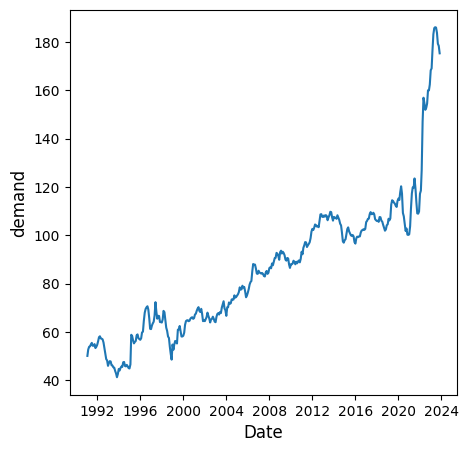

In [373]:
plt.figure(figsize = (5,5))
plt.plot(df['DATE'],df.iloc[:, -1])
plt.xlabel('Date',fontsize=12)
plt.ylabel('demand',fontsize=12)
plt.show()

2. Data scaling and split

In [374]:
def scaling(data, method):
    if method == 'minMax':
        scaler = MinMaxScaler(feature_range=(0, 1))
    else:
        scaler = StandardScaler()
    scaler = scaler.fit(data)
    prices_train_normalized = scaler.transform(data)
    return prices_train_normalized, scaler

In [375]:
def buildDataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        dataX.append(dataset[i:(i + look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [376]:
def data_split(data, method, test_ratio, lookback):
    # scale
    demand_scaled, scaler = scaling(data, method = method)
    
    # split train/test
    demand_train = demand_scaled[:int(len(demand_scaled)*test_ratio)]
    train_index = [i for i in range(int(len(demand_scaled)*test_ratio))]
    demand_test = demand_scaled[int(len(demand_scaled)*test_ratio):]
    test_index = [i for i in range(int(len(demand_scaled)*test_ratio),len(demand_scaled))]
    print(f'訓練資料集長度 {len(demand_train)}')
    print(f'測試資料集長度 {len(demand_test)}')

    # split x/y
    train_x, train_y = buildDataset(demand_train, look_back=lookback)
    test_x, test_y = buildDataset(demand_test, look_back=lookback)

    return demand_scaled, train_index, train_x, train_y, test_index, test_x, test_y, scaler

In [377]:
demand = np.array(df.iloc[:,-1])
demand = demand.reshape((len(demand), 1))

In [378]:
demand_scaled, train_index, train_x, train_y, test_index, test_x, test_y, scaler = data_split(demand, method='minMax', test_ratio=0.3, lookback=1)

訓練資料集長度 118
測試資料集長度 276


3. Build Model

In [379]:
def LSTM_model(X_train, y_train, epochs, batchSize, lookBack):
    # Create model
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(len(X_train), lookBack)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train,y_train, epochs=epochs, batch_size=batchSize)

    # Evaluate the model on the validation set
    mse_scores = []
    mse = model.evaluate(X_train, y_train, verbose=0)
    mse_scores.append(mse)
    
    return model, mse

In [380]:
def LSTM_predict(data, target, model, scaler):
    predict = model.predict(data)
    train_score = math.sqrt(mean_squared_error(target, predict))
    print(f'誤差分數(RMSE)：{np.round(train_score, 3)}')

    pred_inv = scaler.inverse_transform(predict.reshape(-1, 1)).reshape(len(data),1)
    actual_inv = scaler.inverse_transform(target.reshape(-1, 1)).reshape(len(data),1)

    return pred_inv 

In [382]:
# Train model
model, mse = LSTM_model(train_x, train_y, epochs=200, batchSize=10, lookBack=1)

Epoch 1/200
12/12 [==============================] - 2s 4ms/step - loss: 0.0115
Epoch 2/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 4/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 5/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0025
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 8/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 9/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 10/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 11/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 12/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 13/200
12/12 [=================

# (b) Visualize the time rolling prediction

In [383]:
def visualize(train_pred, test_pred, train_index, test_index, scalingMethod):
    plt.plot(df['DATE'], df['demand'], label='Actual Price')
    plt.plot(df['DATE'][train_index[:len(train_pred)]], train_pred, label='Train predicted price')
    plt.plot(df['DATE'][test_index[:len(test_pred)]], test_pred, label='Test predicted price')
    plt.legend()
    plt.title(f'LSTM Model Predictions using {scalingMethod} Scaling')
    plt.show()

4/4 [==============================] - 0s 3ms/step
誤差分數(RMSE)：0.015
9/9 [==============================] - 0s 3ms/step
誤差分數(RMSE)：0.048


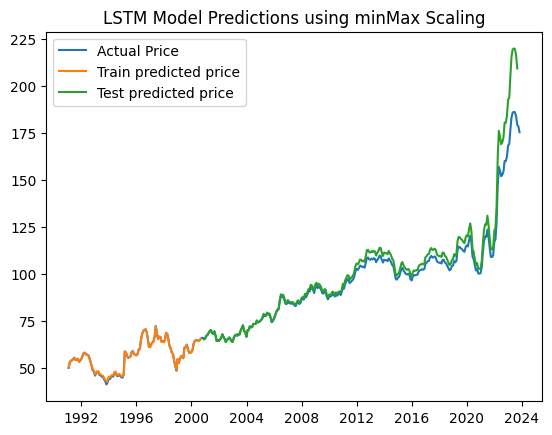

In [384]:
# show model performance
train_predict = LSTM_predict(train_x, train_y, model, scaler)
test_predict = LSTM_predict(test_x, test_y, model, scaler)
visualize(train_predict, test_predict, train_index, test_index, 'minMax')